# Unit05｜Decision Tree 分類入門 + Confusion Matrix

對應講義：`Part_2/Unit05_DecisionTree_Classification.md`


In [1]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'Part_2'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('P2_Unit05_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2


In [2]:
# 匯入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Scikit-learn 相關套件
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

# 建立結果儲存資料夾
OUTPUT_DIR = REPO_ROOT / 'Part_2' / 'P2_Unit05_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(REPO_ROOT / 'Part_2')

# 視覺化設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


---
## 1. 資料準備 (Data Preparation)

我們直接載入 Titanic 資料集，並進行與 Unit 01 相同的前處理步驟：
1.  填補缺失值 (Age, Embarked)。
2.  One-Hot Encoding (Sex, Embarked)。

In [3]:
# 載入資料
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
print("載入並前處理 Titanic 資料集...")
df = pd.read_csv(url)

# 缺失值處理
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

# 選擇要使用的特徵
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# One-Hot Encoding (drop_first=True 避免共線性)
X = pd.get_dummies(df[features], columns=["Sex", "Embarked"], drop_first=True)
y = df["Survived"]

print(f"特徵矩陣 X 形狀: {X.shape}，標籤 y 長度: {len(y)}")
display(X.head())

載入並前處理 Titanic 資料集...
特徵矩陣 X 形狀: (891, 8)，標籤 y 長度: 891


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


---
## 2. 模型訓練 (Model Training)

為了公平評估模型表現，我們不能用「考題」來訓練學生。
因此，我們使用 `train_test_split` 將資料切分為：
-   **訓練集 (Training Set)**：80%，用來教模型。
-   **測試集 (Test Set)**：20%，用來考模型。

In [4]:
# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)
print(f"訓練集大小: {len(X_train)}，測試集大小: {len(X_test)}")

訓練集大小: 712，測試集大小: 179


In [5]:
# 建立並訓練決策樹模型
# max_depth=3 限制樹的深度，避免過擬合並方便視覺化觀察
model = DecisionTreeClassifier(max_depth=3, random_state=42)

# 開始訓練 (Fit)
model.fit(X_train, y_train)

print("✓ 決策樹模型訓練完成。")

✓ 決策樹模型訓練完成。


---
## 3. 模型評估 (Evaluation)

模型訓練好後，我們要用測試集來評估它的準確度。
除了 **Accuracy (準確率)**，在工業應用中我們更看重 **混淆矩陣 (Confusion Matrix)**，了解模型是「誤報」還是「漏報」。

測試集 Accuracy: 79.33%


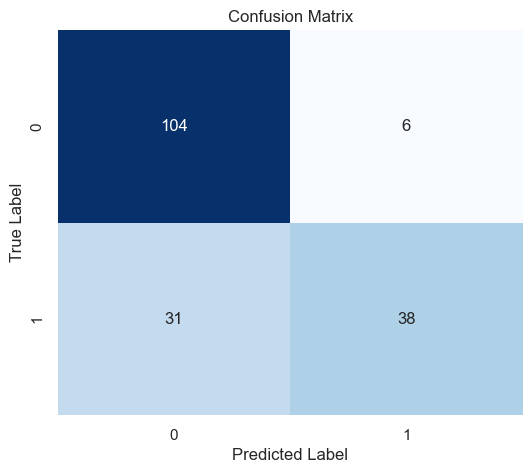

混淆矩陣解析：
TN（預測死、實際死）: 104
FP（預測活、實際死）: 6  → 誤報 (False Positive)
FN（預測死、實際活）: 31  → 漏報 (False Negative)
TP（預測活、實際活）: 38


In [6]:
# 使用測試集進行預測
y_pred = model.predict(X_test)

# 計算準確率
acc = accuracy_score(y_test, y_pred)
print(f"測試集 Accuracy: {acc:.2%}")

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(OUTPUT_DIR / '01_confusion_matrix.png')
plt.show()

# 解析混淆矩陣
tn, fp, fn, tp = cm.ravel()
print("混淆矩陣解析：")
print(f"TN（預測死、實際死）: {tn}")
print(f"FP（預測活、實際死）: {fp}  → 誤報 (False Positive)")
print(f"FN（預測死、實際活）: {fn}  → 漏報 (False Negative)")
print(f"TP（預測活、實際活）: {tp}")

### 3.1 進階：交叉驗證 (Cross-Validation)

在化工實驗中，數據往往很珍貴且數量稀少。如果只切一次 Train/Test，剛好切到比較「簡單」或「極端」的測試資料，評估結果可能不準。

**K-Fold Cross-Validation** 將資料分成 K 個部分 (Folds)，每次輪流用其中 1 份當測試集，其他 K-1 份當訓練集，重複 K 次後取平均。這樣能更穩健地估計模型的真實表現。

In [7]:
from sklearn.model_selection import cross_val_score

# K-Fold 交叉驗證，這裡以 K=5 為例
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# 顯示每一折的準確率
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

# 平均準確率與標準差
print(f"\nMean Accuracy: {scores.mean():.4f}")
print(f"Std Dev:       {scores.std():.4f}")
print("\n💡 若標準差很小（< 2%），代表模型很穩定；若很大，可能是過擬合或數據量不足。")

Fold 1: 0.8156
Fold 2: 0.8146
Fold 3: 0.8146
Fold 4: 0.7809
Fold 5: 0.8202

Mean Accuracy: 0.8092
Std Dev:       0.0143

💡 若標準差很小（< 2%），代表模型很穩定；若很大，可能是過擬合或數據量不足。


## 實務補充：不平衡資料、PR Curve、閾值與錯誤成本

在工廠情境（安全/品質）裡，**Accuracy 常常會誤導**：

- 類別不平衡時，只要一直預測「多數類」就能拿到看似不錯的 Accuracy
- 你真正關心的通常是：**漏報 (FN)** 有多嚴重？**誤報 (FP)** 會造成多少停機/人力成本？

下面用 Titanic 做示範：先看資料是否不平衡，再用 **PR curve** 與 **門檻 (threshold)** 把「工程成本」放進決策。


In [8]:
# 0) 先看類別比例（不平衡程度）
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print('y_train class balance (count):')
print(y_train.value_counts())
print('y_train class balance (ratio):')
print((y_train.value_counts(normalize=True) * 100).round(2).astype(str) + '%')

print('=== Default threshold=0.5 的分類報告 ===')
print(classification_report(y_test, y_pred, digits=3))
print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:   ', round(recall_score(y_test, y_pred), 3))
print('F1:       ', round(f1_score(y_test, y_pred), 3))


y_train class balance (count):
Survived
0    439
1    273
Name: count, dtype: int64
y_train class balance (ratio):
Survived
0    61.66%
1    38.34%
Name: proportion, dtype: object
=== Default threshold=0.5 的分類報告 ===
              precision    recall  f1-score   support

           0      0.770     0.945     0.849       110
           1      0.864     0.551     0.673        69

    accuracy                          0.793       179
   macro avg      0.817     0.748     0.761       179
weighted avg      0.806     0.793     0.781       179

Precision: 0.864
Recall:    0.551
F1:        0.673


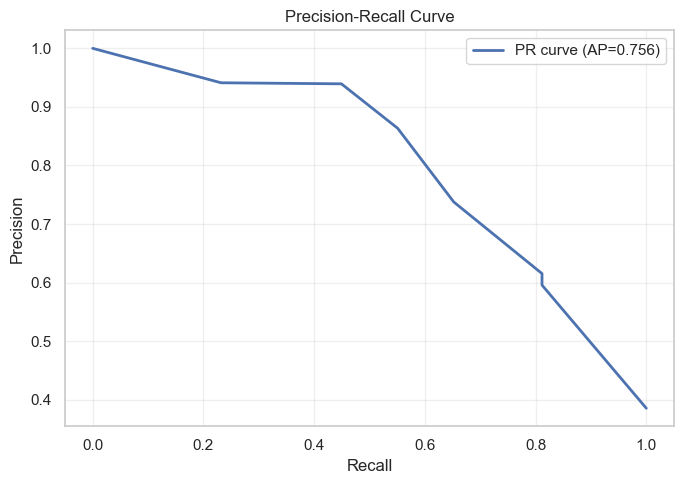

Saved: P2_Unit05_Results/04_pr_curve.png


In [9]:
# 1) PR Curve：在不平衡資料上，比 ROC 更能反映「正類表現」
from sklearn.metrics import precision_recall_curve, average_precision_score

# 機率分數（正類=Survived）
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, linewidth=2, label=f'PR curve (AP={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '04_pr_curve.png', dpi=150)
plt.show()
print('Saved: P2_Unit05_Results/04_pr_curve.png')


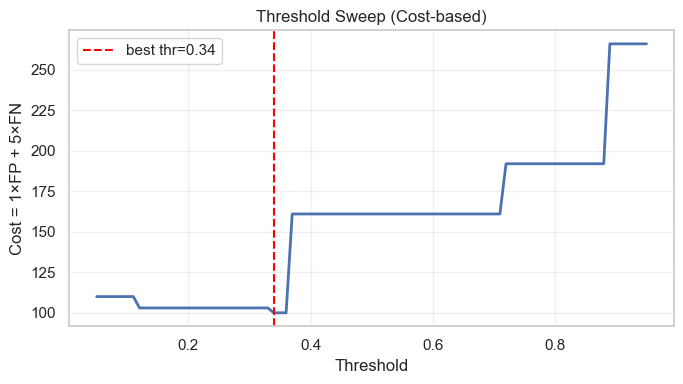

Saved: P2_Unit05_Results/05_threshold_cost.png
Best threshold = 0.34 (cost_fp=1, cost_fn=5)
Confusion matrix (cost-based threshold):
[[75 35]
 [13 56]]
FP=35, FN=13, Total Cost=100
Precision: 0.615
Recall:    0.812
F1:        0.7


In [10]:
# 2) 閾值與錯誤成本：找「最小期望成本」的 threshold
from sklearn.metrics import confusion_matrix

# 成本設定（示範）：漏報(FN) 比誤報(FP) 更嚴重
cost_fp = 1
cost_fn = 5

threshold_grid = np.linspace(0.05, 0.95, 91)
costs = []

for thr in threshold_grid:
    y_hat = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    costs.append(cost_fp * fp + cost_fn * fn)

best_idx = int(np.argmin(costs))
best_thr = float(threshold_grid[best_idx])

plt.figure(figsize=(7, 4))
plt.plot(threshold_grid, costs, linewidth=2)
plt.axvline(best_thr, color='red', linestyle='--', label=f'best thr={best_thr:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Cost = 1×FP + 5×FN')
plt.title('Threshold Sweep (Cost-based)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '05_threshold_cost.png', dpi=150)
plt.show()
print('Saved: P2_Unit05_Results/05_threshold_cost.png')

# 用最佳閾值重算混淆矩陣
y_pred_cost = (y_proba >= best_thr).astype(int)
cm_cost = confusion_matrix(y_test, y_pred_cost)
tn, fp, fn, tp = cm_cost.ravel()

print(f'Best threshold = {best_thr:.2f} (cost_fp={cost_fp}, cost_fn={cost_fn})')
print('Confusion matrix (cost-based threshold):')
print(cm_cost)
print(f'FP={fp}, FN={fn}, Total Cost={cost_fp*fp + cost_fn*fn}')
print('Precision:', round(precision_score(y_test, y_pred_cost), 3))
print('Recall:   ', round(recall_score(y_test, y_pred_cost), 3))
print('F1:       ', round(f1_score(y_test, y_pred_cost), 3))


### 3.2 進階：超參數調校 (Hyperparameter Tuning with Grid Search)

決策樹有許多「旋鈕」可以調整，這些稱為 **超參數 (Hyperparameters)**。調整超參數的過程，本質上是在權衡 **偏差 (Bias)** 與 **變異 (Variance)**。

**Grid Search** 會窮舉所有參數組合，並透過交叉驗證找出使驗證集表現最好的那組參數。

In [11]:
from sklearn.model_selection import GridSearchCV

# 定義參數網格
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 建立 GridSearchCV 物件（5-Fold CV）
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# 執行搜尋
print("正在搜尋最佳超參數組合...")
grid_search.fit(X_train, y_train)

# 輸出最佳參數與分數
print(f"\n最佳參數組合: {grid_search.best_params_}")
print(f"最佳交叉驗證分數: {grid_search.best_score_:.4f}")

# 用最佳模型在測試集上評估
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"測試集準確率 (最佳模型): {acc_best:.4f}")

正在搜尋最佳超參數組合...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

最佳參數組合: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
最佳交叉驗證分數: 0.8217
測試集準確率 (最佳模型): 0.7989


**結果解讀**：
- 如果最佳參數選了 `max_depth=3` 或 `5` 而不是 `None`，這印證了「樹不用太深也能有很好的表現」，太深反而容易過擬合。
- 這就像在化工廠做實驗設計 (DoE)，找到了反應的最佳溫度與壓力設定點。

In [12]:
# 3)（選讀）class_weight='balanced'：用更在乎少數類的方式訓練
from sklearn.metrics import average_precision_score

balanced_model = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
balanced_model.fit(X_train, y_train)

proba_bal = balanced_model.predict_proba(X_test)[:, 1]
ap_bal = average_precision_score(y_test, proba_bal)
print(f'AP (original model): {ap:.3f}')
print(f'AP (class_weight=balanced): {ap_bal:.3f}')


AP (original model): 0.756
AP (class_weight=balanced): 0.762


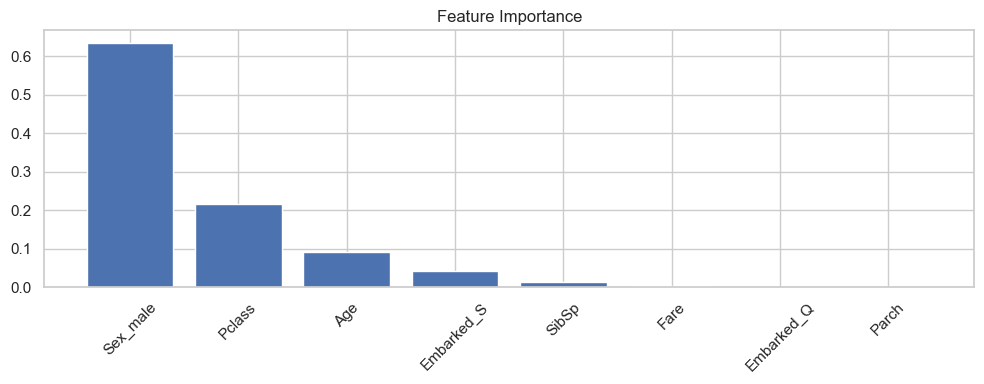

In [13]:
# 1. 特徵重要性 (Feature Importance)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 4))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_feature_importance.png')
plt.show()

繪製決策樹結構中...


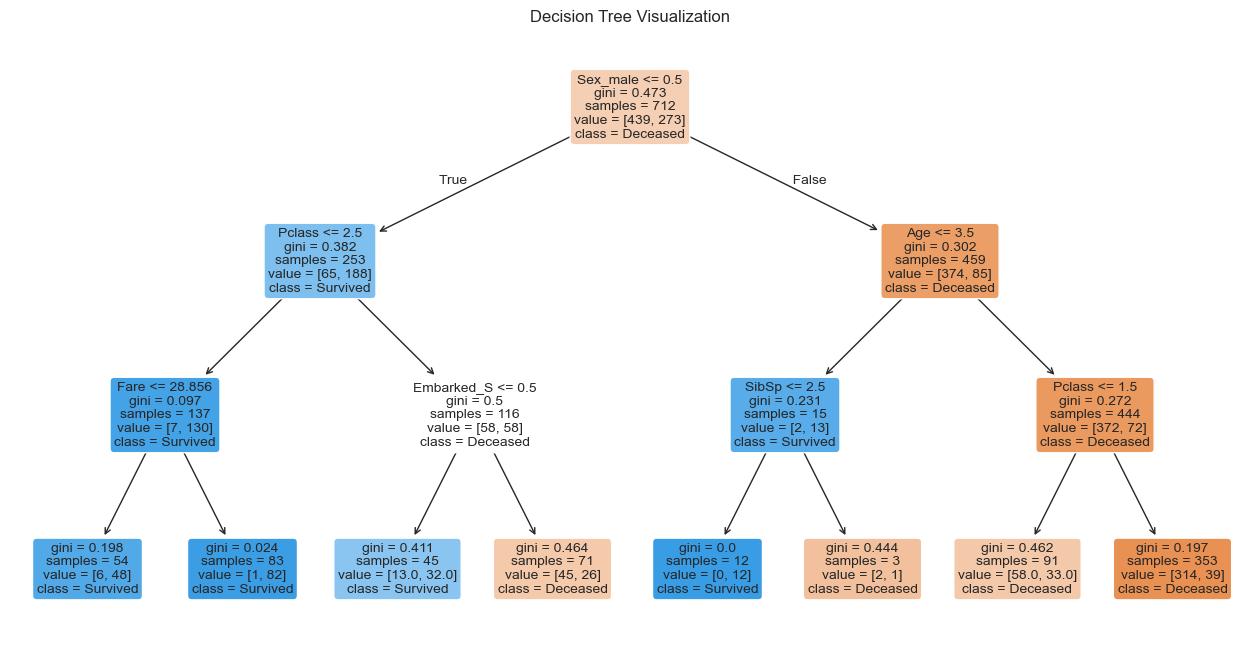

In [14]:
# 2. 決策樹結構視覺化
print("繪製決策樹結構中...")
plt.figure(figsize=(16, 8))
plot_tree(
    model,
    feature_names=feature_names,
    class_names=["Deceased", "Survived"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree Visualization")
plt.savefig(OUTPUT_DIR / '03_decision_tree.png')
plt.show()

---
## 5. 模型保存與部署示意 (Persistence & Deployment)

在實際工廠中，我們不會每次要預測時都重新訓練模型。
我們會將訓練好的模型 **存檔 (Dump)**，然後在生產環境中 **載入 (Load)** 使用。

In [15]:
# 1. 儲存模型
filename = "./P2_Unit05_Results/titanic_tree_model.pkl"
joblib.dump(model, filename)
print(f"✓ 模型已儲存至: {filename}")

# 2. 模擬從硬碟載入模型
loaded_model = joblib.load(filename)
print("✓ 模型載入成功，準備進行模擬預測。")

✓ 模型已儲存至: ./P2_Unit05_Results/titanic_tree_model.pkl
✓ 模型載入成功，準備進行模擬預測。


In [16]:
# 4) 實務交付：簡化版 Model Card（方便審查/交接/上線）
import json
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# 確保需要的變數存在
y_proba_local = model.predict_proba(X_test)[:, 1]
y_pred_local = model.predict(X_test)

thr = globals().get('best_thr', 0.5)

card = {
    'unit': 'Unit05',
    'task': 'Titanic survival classification (demo)',
    'model_type': type(model).__name__,
    'model_params': model.get_params(),
    'data': {
        'source': 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv',
        'n_samples': int(len(X)),
        'n_features_after_onehot': int(X.shape[1]),
        'train_size': int(len(X_train)),
        'test_size': int(len(X_test)),
        'positive_rate_train': float(y_train.mean()),
        'positive_rate_test': float(y_test.mean()),
    },
    'features': list(X.columns),
    'metrics_default_threshold_0.5': {
        'accuracy': float(accuracy_score(y_test, y_pred_local)),
        'precision': float(precision_score(y_test, y_pred_local)),
        'recall': float(recall_score(y_test, y_pred_local)),
        'f1': float(f1_score(y_test, y_pred_local)),
        'average_precision': float(average_precision_score(y_test, y_proba_local)),
    },
    'threshold_policy': {
        'threshold_used': float(thr),
        'note': 'If cost-based threshold search was run, best_thr is used; otherwise default 0.5.',
    },
    'limits': [
        'Demo dataset; do not use for real decision making.',
        'Threshold should be chosen based on business/safety cost.',
    ],
}

out_path = Path('./P2_Unit05_Results/model_card.json')
out_path.write_text(json.dumps(card, ensure_ascii=False, indent=2), encoding='utf-8')
print('Saved:', out_path)


Saved: P2_Unit05_Results\model_card.json


In [17]:
# 3. 準備一筆模擬乘客資料進行預測
# 假設一位乘客：Pclass=3, Age=22, SibSp=0, Parch=0, Fare=7.25, Sex_male=1, Embarked_Q=0, Embarked_S=1
# 注意: 特徵順序必須與訓練時完全一致
print("特徵欄位順序：", list(feature_names))

new_passenger_data = [[3, 22.0, 0, 0, 7.25, 1, 0, 1]]
# 將 list 轉為 DataFrame 並指定欄位名稱，以消除警告
new_passenger = pd.DataFrame(new_passenger_data, columns=feature_names)

# 進行預測
pred = loaded_model.predict(new_passenger)
prob = loaded_model.predict_proba(new_passenger)

result = "存活 (Survived)" if pred[0] == 1 else "死亡 (Deceased)"
print(f"\n對模擬乘客的預測結果：{result}")
print(f"機率分布 → 死亡 {prob[0][0]:.2f}，存活 {prob[0][1]:.2f}")

特徵欄位順序： ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']

對模擬乘客的預測結果：死亡 (Deceased)
機率分布 → 死亡 0.89，存活 0.11


---
## 6. 化工專題：反應器異常偵測 (Reactor Fault Detection)

除了 Titanic 生存預測，決策樹非常適合用於化工製程的 **異常偵測 (Fault Detection)**。

### 情境與理論分析

假設我們有一個連續攪拌槽反應器 (CSTR)，監控變數為 **溫度 (T)** 與 **壓力 (P)**：
- 當 T > 180°C 時，反應失控
- 當 T > 160°C 且 P > 8 bar 時，壓力過大導致洩漏風險

決策樹的決策邊界是由**垂直於特徵軸的超平面**所組成，非常擅長學習像 `IF T > 180` 這樣的規則（垂直切分），這與化工操作規程 (SOP) 的邏輯完全一致。

In [18]:
# 生成模擬反應器數據
np.random.seed(42)
n = 800

# 生成操作條件（溫度與壓力）
T = np.random.uniform(140, 200, n)  # Temperature (°C)
P = np.random.uniform(4, 10, n)     # Pressure (bar)

# 定義異常判斷規則（化工安全邊界）
def is_fault(temp, pressure):
    """定義反應器異常條件"""
    # 規則 1: 高溫危險
    if temp > 180:
        return 1
    # 規則 2: 中高溫 + 高壓危險
    if temp > 160 and pressure > 8:
        return 1
    # 安全區域
    return 0

# 生成標籤（0=安全, 1=異常）
Status = np.array([is_fault(t, p) for t, p in zip(T, P)])

# 整理成 DataFrame
df_reactor = pd.DataFrame({'Temperature': T, 'Pressure': P, 'Status': Status})

print(f"數據形狀: {df_reactor.shape}")
print(f"異常樣本比例: {Status.mean():.2%}")
print("\n前幾筆數據：")
print(df_reactor.head())

數據形狀: (800, 3)
異常樣本比例: 44.25%

前幾筆數據：
   Temperature  Pressure  Status
0   162.472407  8.243432       1
1   197.042858  4.915234       1
2   183.919637  7.457730       1
3   175.919509  7.640290       0
4   149.361118  6.544784       0


反應器異常偵測準確率: 1.0000


c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


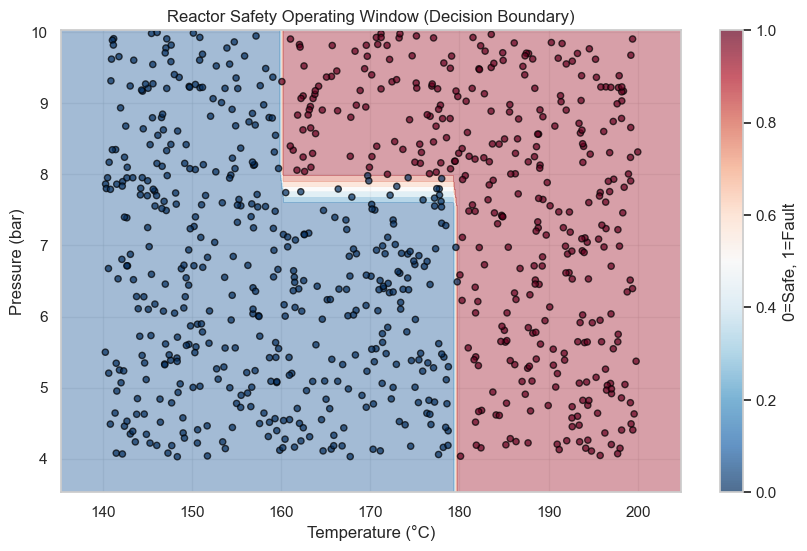

✓ 決策邊界圖已儲存至 P2_Unit05_Results/06_reactor_boundary.png


In [19]:
# 訓練決策樹偵測異常
X_reactor = df_reactor[['Temperature', 'Pressure']]
y_reactor = df_reactor['Status']

# 切分訓練/測試集
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reactor, y_reactor, test_size=0.2, random_state=42, stratify=y_reactor
)

# 訓練決策樹（限制深度避免過擬合）
reactor_model = DecisionTreeClassifier(max_depth=4, random_state=42)
reactor_model.fit(X_train_r, y_train_r)

# 評估模型
y_pred_r = reactor_model.predict(X_test_r)
acc_r = accuracy_score(y_test_r, y_pred_r)
print(f"反應器異常偵測準確率: {acc_r:.4f}")

# 繪製決策邊界
h = 0.5  # 網格步長
x_min, x_max = T.min() - 5, T.max() + 5
y_min, y_max = P.min() - 0.5, P.max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 預測網格點的類別
Z = reactor_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 視覺化
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu_r')
plt.scatter(T, P, c=Status, cmap='RdBu_r', edgecolor='black', s=20, alpha=0.7)
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (bar)')
plt.title('Reactor Safety Operating Window (Decision Boundary)')
plt.colorbar(label='0=Safe, 1=Fault')
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / '06_reactor_boundary.png', dpi=150)
plt.show()

print("✓ 決策邊界圖已儲存至 P2_Unit05_Results/06_reactor_boundary.png")

### 圖形詳細解析

1. **幾何特性**：
   - 注意紅色與藍色交界的線條，它們全部都是 **水平線** 或 **垂直線**。這是決策樹的特性：它只能做 `X > Value` 這種單一變數的切分。
   - **垂直線 (T ≈ 180)**：對應規則 `T > 180`
   - **L型缺口 (T > 160 & P > 8)**：右上方的矩形危險區

2. **化工意義**：
   - 這張圖就是一張 **操作視窗 (Operating Window)** 圖
   - 透過機器學習，我們不需要人工去畫這些線，模型會自動從歷史數據中找出安全邊界
   - 如果未來有新的操作點落在紅色區域，系統就可以發出警報

---

## 總結

- 你已完成第一個可解釋分類模型（決策樹）。
- 你能用 Confusion Matrix 與 Feature Importance 解讀模型。

下一堂：`Part_2/Unit06_CV_Model_Selection.ipynb`（CV / Grid Search / 化工安全邊界）。


---

## 7. 課後練習：流體流動模式分類 (Flow Regime Classification)

為了讓同學練習 **多類別分類 (Multi-class Classification)**，我們準備了一個流體力學的案例。

### 背景

在化工管路設計中，氣液雙相流 (Gas-Liquid Two-Phase Flow) 的流動模式對於壓降計算與熱傳效率至關重要。常見的模式包含：
- **Bubble Flow (泡狀流)** (類別 0)：液體為主，氣體以小氣泡分散其中
- **Slug Flow (栓狀流)** (類別 1)：氣泡聚集成大氣塞，流動不穩定
- **Annular Flow (環狀流)** (類別 2)：氣體在中心高速流動，液體沿管壁成膜狀

### 任務

在下方程式碼中，我們提供了一組模擬數據，包含氣體表觀流速 ($V_{sg}$) 與液體表觀流速 ($V_{sl}$)。請嘗試：

1. 建立決策樹模型
2. 畫出決策邊界圖，觀察模型如何區分這三種流動模式

**提示**：這與反應器異常偵測非常像，只是標籤 $y$ 變成了 0, 1, 2 三種類別。

In [20]:
# 生成模擬流動模式數據
np.random.seed(101)
n_samples = 600

# 氣體表觀流速 (Superficial Gas Velocity, m/s)
V_sg = np.random.uniform(0.1, 5.0, n_samples)
# 液體表觀流速 (Superficial Liquid Velocity, m/s)
V_sl = np.random.uniform(0.05, 2.0, n_samples)

# 定義流動模式分類規則（簡化版 Baker Chart）
def classify_flow_regime(vsg, vsl):
    """根據流速分類流動模式"""
    if vsg < 1.0:
        return 0  # Bubble Flow (泡狀流)
    elif vsg < 3.0 and vsl > 0.5:
        return 1  # Slug Flow (栓狀流)
    else:
        return 2  # Annular Flow (環狀流)

# 生成標籤
Regime = np.array([classify_flow_regime(vsg, vsl) for vsg, vsl in zip(V_sg, V_sl)])

# 整理成 DataFrame
df_flow = pd.DataFrame({'V_sg': V_sg, 'V_sl': V_sl, 'Regime': Regime})

print(f"數據形狀: {df_flow.shape}")
print("\n各流動模式的樣本數：")
print(df_flow['Regime'].value_counts().sort_index())
print("\n前幾筆數據：")
print(df_flow.head())

數據形狀: (600, 3)

各流動模式的樣本數：
Regime
0    107
1    190
2    303
Name: count, dtype: int64

前幾筆數據：
       V_sg      V_sl  Regime
0  2.630353  0.975273       1
1  2.896271  1.147367       1
2  0.239524  0.960524       0
3  0.940456  1.434759       0
4  3.457857  0.782813       2


### 練習題：完成以下程式碼

```python
# 1. 準備數據
X_flow = df_flow[['V_sg', 'V_sl']]
y_flow = df_flow['Regime']

# 2. 訓練決策樹（提示：多類別分類的用法與二元分類完全相同）
flow_model = DecisionTreeClassifier(max_depth=5, random_state=42)
flow_model.fit(X_flow, y_flow)

# 3. 計算準確率
y_pred_flow = flow_model.predict(X_flow)
acc_flow = accuracy_score(y_flow, y_pred_flow)
print(f"流動模式分類準確率: {acc_flow:.4f}")

# 4. 繪製決策邊界（參考反應器異常偵測的程式碼）
# 提示：使用 plt.contourf() 和 plt.scatter() 繪製
# 可以使用 cmap='viridis' 來區分三種顏色

# TODO: 請同學自行完成視覺化程式碼
```

**預期結果**：
- 你應該會看到三個不同顏色的區域，分別代表泡狀流、栓狀流、環狀流
- 決策邊界應該呈現水平或垂直的直線（決策樹特性）